## Import Libraries

In [1465]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Read Data & Membuat DataFrame

In [1466]:
# read data

cycle = pd.read_csv('cycles.csv')
ponds = pd.read_csv('ponds.csv')
farms = pd.read_csv('farms.csv')
feeds = pd.read_csv('feeds.csv')
fasting = pd.read_csv('fasting.csv')
harvests = pd.read_csv('harvests.csv')
sampling = pd.read_csv('samplings.csv')
measurements = pd.read_csv('measurements.csv')

In [1467]:
# cek data duplikat
duplikat = cycle.duplicated().sum()
print(f'Terdapat {duplikat} data duplikat')

Terdapat 6 data duplikat


In [1468]:
# Menghapus data duplikat
cycle = cycle.drop_duplicates()
duplikat = cycle.duplicated().sum()
print(f'Terdapat {duplikat} data duplikat')

Terdapat 0 data duplikat


In [1469]:
# Untuk memudahkan penggabungan data, primary key diubah sesuai nama variabel

cycle.rename(columns={'id': 'cycle_id'}, inplace=True)
ponds.rename(columns={'id': 'pond_id'}, inplace=True)
farms.rename(columns={'id': 'farm_id'}, inplace=True)
harvests.rename(columns={'id': 'harvest_id'}, inplace=True)

In [1470]:
harvests['harvested_at'] = pd.to_datetime(harvests['harvested_at'])
harvests['year_harvest'] = harvests['harvested_at'].dt.year

In [1471]:
weightpercycle = harvests.groupby('cycle_id')['weight'].sum().reset_index(name='total_weight')

In [1472]:
# menggabungkan data

gabung = pd.merge(cycle, ponds, how='left', on='pond_id')
gabung = pd.merge(gabung, farms, how='left', on='farm_id')
gabung = pd.merge(gabung, weightpercycle, how='left', on='cycle_id')
gabung.head()

,cycle_id,pond_id,total_seed,started_at,finished_at,area,farm_id,length,width,deep,province,regency,timezone,total_weight
0,18360,33945,400000,2022-12-01 00:00:00.000,2023-02-17 00:00:00.000,699.90,7926,30.00,30.00,1.50,JAWA TENGAH,KENDAL,+07:00,9883.62
1,14583,31451,155792,2022-05-15 00:00:00.000,2022-07-23 00:00:00.000,1000.00,8405,50.96,38.22,1.20,NaN,NaN,+07:00,361.24
2,19049,13249,175000,2022-06-30 00:00:00.000,2022-10-12 00:00:00.000,2256.25,2527,54.83,41.12,3.00,LAMPUNG,PESAWARAN,+07:00,3399.61
3,16334,7369,400200,2022-09-19 00:00:00.000,2023-01-21 00:00:00.000,2820.00,8321,61.10,45.83,1.25,JAWA TENGAH,CILACAP,+07:00,4072.21
4,18740,31447,169702,2022-05-15 00:00:00.000,2022-07-23 00:00:00.000,1000.00,8405,53.14,39.86,1.20,NaN,NaN,+07:00,98.66


In [1473]:
gabung.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cycle_id      500 non-null    int64  
 1   pond_id       500 non-null    int64  
 2   total_seed    500 non-null    int64  
 3   started_at    500 non-null    object 
 4   finished_at   500 non-null    object 
 5   area          500 non-null    float64
 6   farm_id       500 non-null    int64  
 7   length        500 non-null    float64
 8   width         500 non-null    float64
 9   deep          496 non-null    float64
 10  province      443 non-null    object 
 11  regency       424 non-null    object 
 12  timezone      500 non-null    object 
 13  total_weight  500 non-null    float64
dtypes: float64(5), int64(4), object(5)
memory usage: 54.8+ KB


In [1474]:
# jumlah siklus
harvests.groupby('year_harvest')['cycle_id'].size()

year_harvest
2018      1
2020      1
2021    132
2022    912
2023    824
Name: cycle_id, dtype: int64

## Over View

In [1475]:
berat_udang = harvests['weight'].sum()
print(f'Total berat udang yang berhasil dipanen {berat_udang} Kg')

Total berat udang yang berhasil dipanen 1336817.26 Kg


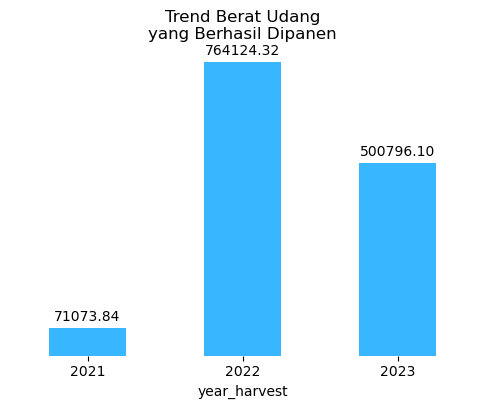

In [1476]:
# Membuat figure dan axis
plt.figure(figsize=(6, 4))

# Menyaring data dan membuat plot batang
filtered_harvests = harvests[~((harvests['year_harvest'] == 2020) | (harvests['year_harvest'] == 2018))]
harvest_data = filtered_harvests.groupby('year_harvest')['weight'].sum()
bars = harvest_data.plot(kind='bar', color='#38b6ff')

# Menambahkan judul dan mengatur rotasi label x-axis
plt.title('Trend Berat Udang\nyang Berhasil Dipanen')
plt.xticks(rotation=360)

# Menghilangkan bingkai
bars.spines['top'].set_visible(False)
bars.spines['right'].set_visible(False)
bars.spines['left'].set_visible(False)
bars.spines['bottom'].set_visible(False)

# Menghilangkan yticks
bars.yaxis.set_ticks([])

# Menambahkan label nilai di atas setiap batang
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='center',
                  size=10, xytext=(0, 8),
                  textcoords='offset points')

# Menampilkan plot
plt.ylabel('')
plt.show()

In [1477]:
count_pond = ponds['pond_id'].count()
print(f'Jumlah kolam : {count_pond}')

Jumlah kolam : 431


In [1478]:
tambak = farms['farm_id'].nunique()
print(f'Jumlah Tambak : {tambak}')

Jumlah Tambak : 160


In [1479]:
kabkota = farms['regency'].nunique()
prov = farms['province'].nunique()
print(f'Jumlah Kabupaten/Kota : {kabkota}')
print(f'Jumlah Provinsi: {prov}')

Jumlah Kabupaten/Kota : 35
Jumlah Provinsi: 14


In [1480]:
area = round(cycle['area'].sum()/10000, 2)
print(f'Total luas area kolam: {area} Hektar')

Total luas area kolam: 106.66 Hektar


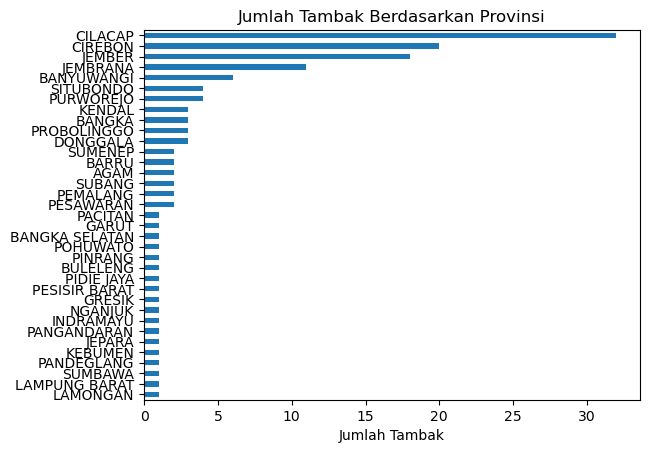

In [1481]:
farms.groupby('regency')['farm_id'].nunique().sort_values().plot(kind='barh')
plt.ylabel('')
plt.xlabel('Jumlah Tambak')
plt.title ('Jumlah Tambak Berdasarkan Provinsi')
plt.show()

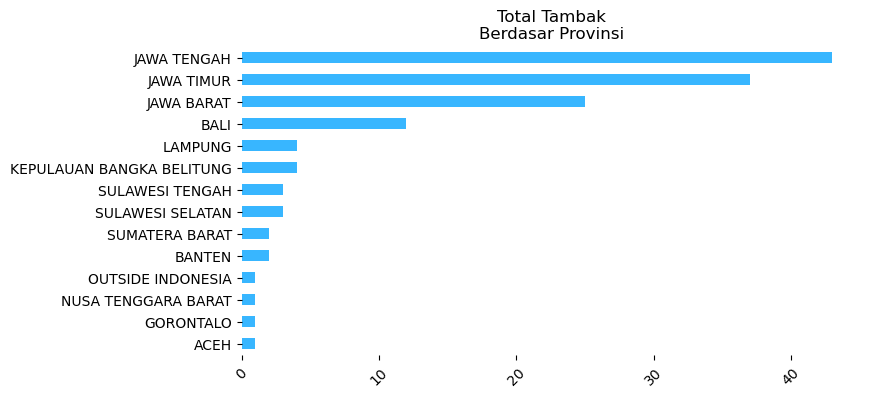

In [1482]:
plt.figure(figsize=(8,4))
bars = gabung.groupby('province')['farm_id'].nunique().sort_values().plot(kind='barh', color='#38b6ff')
plt.title('Total Tambak\nBerdasar Provinsi')

bars.spines['top'].set_visible(False)
bars.spines['right'].set_visible(False)
bars.spines['left'].set_visible(False)
bars.spines['bottom'].set_visible(False)

plt.ylabel('')
plt.xticks(rotation=45)
plt.show()

In [1483]:
feeds['year'] = pd.to_datetime(feeds['logged_at']).dt.year

In [1484]:
ton_feed = (feeds['quantity'].sum()/1000).astype(int)
print(f'Total pakan yang diberikan = {ton_feed} ton')

Total pakan yang diberikan = 1966 ton


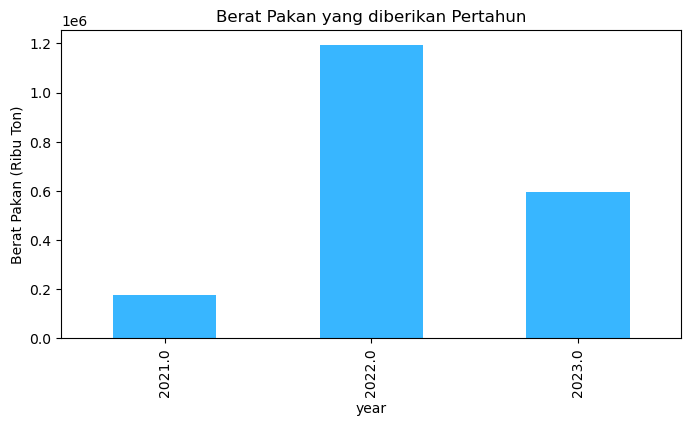

In [1485]:
plt.figure(figsize=(8,4))
feeds[(feeds['year']==2021) | (feeds['year']==2022) | (feeds['year']==2023)].groupby('year')['quantity'].sum().plot(kind='bar', color='#38b6ff')
plt.title('Berat Pakan yang diberikan Pertahun')
plt.ylabel('Berat Pakan (Ribu Ton)')
plt.show()

## Menghitung SR

SR adalah Jumlah (Persentase) ekor udang yang dipanen dalam suatu siklus budidaya terhadap jumlah benur udang yang ditebar.
Untuk menghitung SR dibutuhkan data total ekor udang saat panen dan total benih yang ditebar per siklus.

In [1486]:
harvests.head()

,cycle_id,size,weight,harvest_id,harvested_at,status,year_harvest
0,15308,119.78,481.20,15542.0,2023-01-03,Partial,2023
1,15308,119.78,65.54,15543.0,2023-01-03,Partial,2023
2,15308,63.42,111.66,15919.0,2023-01-21,Partial,2023
3,15308,113.57,180.09,15920.0,2023-01-21,Partial,2023
4,15308,113.57,346.57,15921.0,2023-01-21,Partial,2023


In [1487]:
# menghitung total udang saat panen per siklus
harvests['total_shrimp'] = (harvests['size']*harvests['weight']).astype(int)
shrimp = harvests.groupby('cycle_id')['total_shrimp'].sum().reset_index(name='total_shrimp')
shrimp.head()

,cycle_id,total_shrimp
0,7615,168537
1,7616,41000
2,9090,112216
3,9091,57534
4,9094,31050


In [1488]:
# menggabungkan data ke df sebelumnya
gabung = pd.merge(gabung, shrimp, how='left', on='cycle_id')
# menghitung nilai SR dengan membagi total udang saat panen dengan total benih yang ditabur
gabung['SR'] = round((gabung['total_shrimp']/gabung['total_seed'])*100,2)
gabung.head()

,cycle_id,pond_id,total_seed,started_at,finished_at,area,farm_id,length,width,deep,province,regency,timezone,total_weight,total_shrimp,SR
0,18360,33945,400000,2022-12-01 00:00:00.000,2023-02-17 00:00:00.000,699.90,7926,30.00,30.00,1.50,JAWA TENGAH,KENDAL,+07:00,9883.62,811975,202.99
1,14583,31451,155792,2022-05-15 00:00:00.000,2022-07-23 00:00:00.000,1000.00,8405,50.96,38.22,1.20,NaN,NaN,+07:00,361.24,40179,25.79
2,19049,13249,175000,2022-06-30 00:00:00.000,2022-10-12 00:00:00.000,2256.25,2527,54.83,41.12,3.00,LAMPUNG,PESAWARAN,+07:00,3399.61,193775,110.73
3,16334,7369,400200,2022-09-19 00:00:00.000,2023-01-21 00:00:00.000,2820.00,8321,61.10,45.83,1.25,JAWA TENGAH,CILACAP,+07:00,4072.21,373281,93.27
4,18740,31447,169702,2022-05-15 00:00:00.000,2022-07-23 00:00:00.000,1000.00,8405,53.14,39.86,1.20,NaN,NaN,+07:00,98.66,16535,9.74


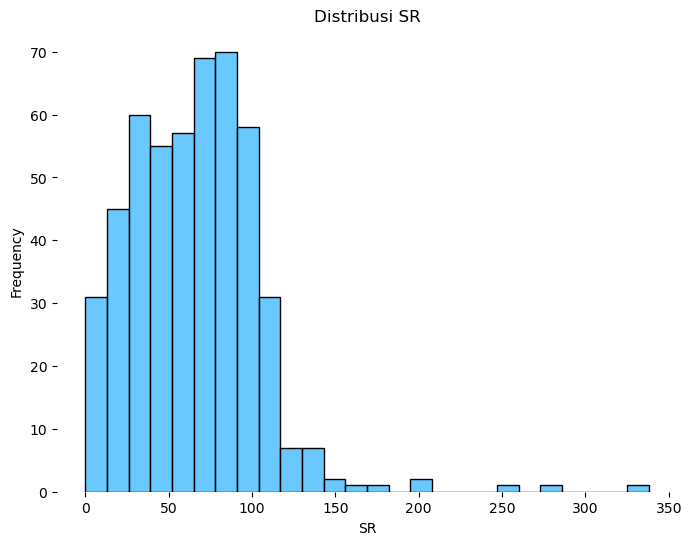

In [1489]:
# Membuat histogram dengan seaborn
plt.figure(figsize=(8, 6))
sns.histplot(gabung[gabung['SR'] < 10000]['SR'], color='#38b6ff')

# Mengatur judul dan label sumbu
plt.title('Distribusi SR')
plt.xlabel('SR')
plt.ylabel('Frequency')

# Menghilangkan bingkai
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Menampilkan plot
plt.show()

In [1490]:
gabung['SR'].max()

12155.1

## Menghitung ADG

Average Daily Gain (ADG) adalah rerata pertumbuhan berat udang. Nilai ADG diperoleh saat petambak melakukan sampling dan panen. Nilai ADG diperoleh dengan mencari selisih ABW antar sampling yang berdekatan dan membandingkannya dengan jarak waktu (hari) antar sampling.

In [1491]:
# mensortir data sesuai siklus dan tanggal pengukuran
sampling = sampling.sort_values(by=['cycle_id', 'sampled_at'])

# mengganti tipe objek menjadi datetime
sampling['sampled_at'] = pd.to_datetime(sampling['sampled_at'])

# Menghitung selisih ABW dan selisih waktu antar sampling
sampling['abw_diff'] = sampling.groupby('cycle_id')['average_weight'].diff()
sampling['days_diff'] = sampling.groupby('cycle_id')['sampled_at'].diff().dt.days

# Menghitung ADG
sampling['ADG'] = sampling['abw_diff'] / sampling['days_diff']

In [1492]:
sampling.head()

,cycle_id,sampled_at,average_weight,abw_diff,days_diff,ADG
3491,7615,2023-02-01,1.30,NaN,NaN,NaN
3492,7615,2023-02-08,2.90,1.60,7.0,0.228571
3493,7615,2023-02-15,4.85,1.95,7.0,0.278571
3494,7615,2023-02-21,5.66,0.81,6.0,0.135000
3495,7615,2023-02-22,5.66,0.00,1.0,0.000000


In [1493]:
# membuat dataframe baru untuk mendapatkan rata-rata ADG per siklus
ADG = sampling.groupby('cycle_id')['ADG'].mean().reset_index(name='ADG')

# menggabungkan data ADG ke dataframe sebelumnya
gabung = pd.merge(gabung, ADG, how='left', on='cycle_id')

In [1494]:
gabung.head()

,cycle_id,pond_id,total_seed,started_at,finished_at,area,farm_id,length,width,deep,province,regency,timezone,total_weight,total_shrimp,SR,ADG
0,18360,33945,400000,2022-12-01 00:00:00.000,2023-02-17 00:00:00.000,699.90,7926,30.00,30.00,1.50,JAWA TENGAH,KENDAL,+07:00,9883.62,811975,202.99,NaN
1,14583,31451,155792,2022-05-15 00:00:00.000,2022-07-23 00:00:00.000,1000.00,8405,50.96,38.22,1.20,NaN,NaN,+07:00,361.24,40179,25.79,0.216667
2,19049,13249,175000,2022-06-30 00:00:00.000,2022-10-12 00:00:00.000,2256.25,2527,54.83,41.12,3.00,LAMPUNG,PESAWARAN,+07:00,3399.61,193775,110.73,0.272708
3,16334,7369,400200,2022-09-19 00:00:00.000,2023-01-21 00:00:00.000,2820.00,8321,61.10,45.83,1.25,JAWA TENGAH,CILACAP,+07:00,4072.21,373281,93.27,0.128571
4,18740,31447,169702,2022-05-15 00:00:00.000,2022-07-23 00:00:00.000,1000.00,8405,53.14,39.86,1.20,NaN,NaN,+07:00,98.66,16535,9.74,0.116190


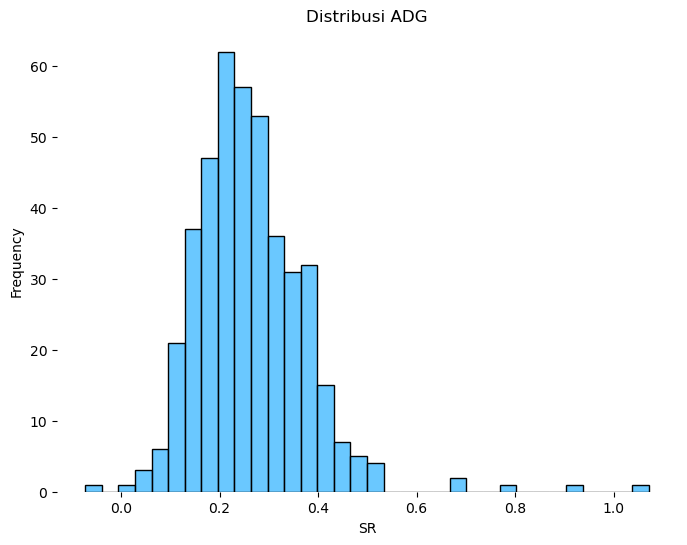

In [1495]:
# Membuat histogram dengan seaborn
plt.figure(figsize=(8, 6))
sns.histplot(gabung['ADG'], color='#38b6ff')

# Mengatur judul dan label sumbu
plt.title('Distribusi ADG')
plt.xlabel('SR')
plt.ylabel('Frequency')

# Menghilangkan bingkai
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Menampilkan plot
plt.show()

In [1496]:
gabung['ADG'].max()

1.0714285714285714

## Menghitung FCR

Feed Conversion Ratio (FCR) adalah salah satu ukuran efisiensi budidaya. FCR menggambarkan berapa kilogram udang yang dapat dihasilkan dari setiap kilogram pakan yang digunakan. FCR diperoleh dengan membandingkan total pakan yang digunakan selama budidaya terhadap total berat udang yang dapat dipanen. Kedua hal tersebut dibandingkan dengan menggunakan satuan yang sama, misal kilogram.

In [1497]:
feeds.head()

,cycle_id,logged_at,quantity,year
0,15308,2022-11-02 00:00:00.000,2.11,2022.0
1,15308,2022-11-02 03:30:00.000,2.11,2022.0
2,15308,2022-11-02 05:30:00.000,2.11,2022.0
3,15308,2022-11-03 00:00:00.000,2.32,2022.0
4,15308,2022-11-03 03:30:00.000,2.32,2022.0


In [1498]:
# Menghitung nilai total pakan per siklus
feedpercycle = feeds.groupby('cycle_id')['quantity'].sum().reset_index(name='total_feed')

# Menghitung nilai total berat udang saat panen per siklus
weightpercycle = harvests.groupby('cycle_id')['weight'].sum().reset_index(name='total_weight')

# menghitung FCR dengan membagi total pakan dengan total berat udang saat panen persiklus
fcr = pd.merge(feedpercycle, weightpercycle, how='inner', on='cycle_id')
fcr['FCR'] = round(fcr['total_feed']/fcr['total_weight'],2)
fcr = fcr.drop('total_weight', axis=True)

In [1499]:
# menggabungkan data FCR dengan dataframe sebelumnya
gabung = pd.merge(gabung, fcr, how='left', on='cycle_id')

In [1500]:
gabung.head()

,cycle_id,pond_id,total_seed,started_at,finished_at,area,farm_id,length,width,deep,province,regency,timezone,total_weight,total_shrimp,SR,ADG,total_feed,FCR
0,18360,33945,400000,2022-12-01 00:00:00.000,2023-02-17 00:00:00.000,699.90,7926,30.00,30.00,1.50,JAWA TENGAH,KENDAL,+07:00,9883.62,811975,202.99,NaN,5596.725,0.57
1,14583,31451,155792,2022-05-15 00:00:00.000,2022-07-23 00:00:00.000,1000.00,8405,50.96,38.22,1.20,NaN,NaN,+07:00,361.24,40179,25.79,0.216667,667.000,1.85
2,19049,13249,175000,2022-06-30 00:00:00.000,2022-10-12 00:00:00.000,2256.25,2527,54.83,41.12,3.00,LAMPUNG,PESAWARAN,+07:00,3399.61,193775,110.73,0.272708,4383.000,1.29
3,16334,7369,400200,2022-09-19 00:00:00.000,2023-01-21 00:00:00.000,2820.00,8321,61.10,45.83,1.25,JAWA TENGAH,CILACAP,+07:00,4072.21,373281,93.27,0.128571,7315.000,1.80
4,18740,31447,169702,2022-05-15 00:00:00.000,2022-07-23 00:00:00.000,1000.00,8405,53.14,39.86,1.20,NaN,NaN,+07:00,98.66,16535,9.74,0.116190,382.500,3.88


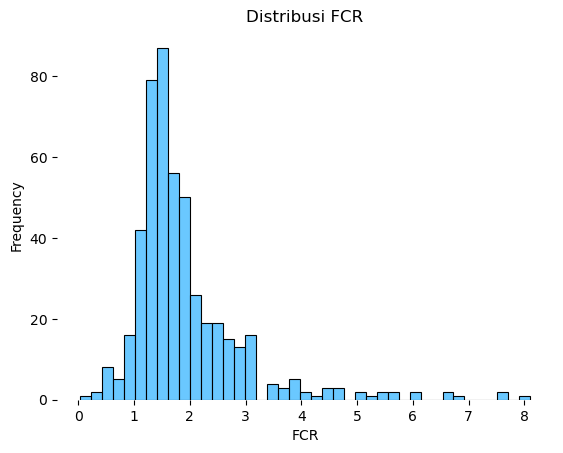

In [1501]:
sns.histplot(gabung[gabung['FCR']<10]['FCR'], color='#38b6ff')

# Mengatur judul dan label sumbu
plt.title('Distribusi FCR')
plt.xlabel('FCR')
plt.ylabel('Frequency')

# Menghilangkan bingkai
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Menampilkan plot
plt.show();

In [1502]:
gabung['FCR'].median()

1.64

In [1503]:
kolam = gabung[['cycle_id', 'started_at', 'finished_at', 'total_seed','area','length','width','deep', 'total_feed','SR','ADG','FCR']]
kolam['volume'] = round(kolam['length']*kolam['width']*kolam['deep'],2)
kolam['padat_tebar'] = round(kolam['total_seed']/kolam['area'],2)
kolam = kolam.drop(['length','width','deep','total_seed'], axis=1)
kolam['started_at'] = pd.to_datetime(kolam['started_at']).dt.date
kolam['finished_at'] = pd.to_datetime(kolam['finished_at']).dt.date

C:\Users\Warnacom\AppData\Local\Temp\ipykernel_6516\3914617128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kolam['volume'] = round(kolam['length']*kolam['width']*kolam['deep'],2)
C:\Users\Warnacom\AppData\Local\Temp\ipykernel_6516\3914617128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kolam['padat_tebar'] = round(kolam['total_seed']/kolam['area'],2)


In [1504]:
kolam.isnull().sum()

cycle_id        0
started_at      0
finished_at     0
area            0
total_feed      0
SR              0
ADG            76
FCR             0
volume          4
padat_tebar     0
dtype: int64

In [1505]:
kolam['ADG'] = kolam['ADG'].fillna(kolam['ADG'].median())
kolam['volume'] = kolam['volume'].fillna(kolam['volume'].median())

In [1506]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Membuang outlier dari kolom SR
data_cleaned = remove_outliers(kolam, 'SR')

# Membuang outlier dari kolom ADG
data_cleaned = remove_outliers(data_cleaned, 'ADG')

# Membuang outlier dari kolom FCR
data_cleaned = remove_outliers(data_cleaned, 'FCR')

In [1507]:
# Menghitung persentil
percentiles = data_cleaned['volume'].quantile([0.25, 0.75]).tolist()

# Definisikan kategori berdasarkan persentil
conditions = [
    (data_cleaned['volume'] <= percentiles[0]),
    (data_cleaned['volume'] > percentiles[0]) & (data_cleaned['volume'] <= percentiles[1]),
    (data_cleaned['volume'] > percentiles[1])
]

choices = ['Kecil', 'Sedang', 'Besar']

data_cleaned['volume_category'] = pd.cut(data_cleaned['volume'], bins=[0, percentiles[0], percentiles[1], data_cleaned['volume'].max()], labels=choices)

In [1508]:
# Menghitung persentil
percentiles = data_cleaned['area'].quantile([0.25, 0.75]).tolist()

# Definisikan kategori berdasarkan persentil
conditions = [
    (data_cleaned['area'] <= percentiles[0]),
    (data_cleaned['area'] > percentiles[0]) & (data_cleaned['area'] <= percentiles[1]),
    (data_cleaned['area'] > percentiles[1])
]

choices = ['Sempit', 'Sedang', 'Luas']

data_cleaned['area_category'] = pd.cut(data_cleaned['area'], bins=[0, percentiles[0], percentiles[1], data_cleaned['area'].max()], labels=choices)

In [1509]:
data_cleaned['started_at'] = pd.to_datetime(data_cleaned['started_at'], format='%Y-%m-%d')
data_cleaned['finished_at'] = pd.to_datetime(data_cleaned['finished_at'], format='%Y-%m-%d')
data_cleaned['cycle_duration'] = (data_cleaned['finished_at'] - data_cleaned['started_at']).dt.days

bins = [0, 60, 120, np.inf]
labels = ['Pendek', 'Sedang', 'Panjang']
data_cleaned['cycle_duration_category'] = pd.cut(data_cleaned['cycle_duration'], bins=bins, labels=labels)

In [1510]:
data_cleaned.head()

,cycle_id,started_at,finished_at,area,total_feed,SR,ADG,FCR,volume,padat_tebar,volume_category,area_category,cycle_duration,cycle_duration_category
1,14583,2022-05-15,2022-07-23,1000.00,667.00,25.79,0.216667,1.85,2337.23,155.79,Sedang,Sempit,69,Sedang
2,19049,2022-06-30,2022-10-12,2256.25,4383.00,110.73,0.272708,1.29,6763.83,77.56,Besar,Sedang,104,Sedang
3,16334,2022-09-19,2023-01-21,2820.00,7315.00,93.27,0.128571,1.80,3500.27,141.91,Sedang,Luas,124,Panjang
5,19518,2022-07-28,2022-09-30,1000.00,893.05,37.27,0.246726,2.08,1400.01,150.00,Sedang,Sempit,64,Sedang
6,15005,2022-03-30,2022-06-10,1662.00,2909.00,78.39,0.259479,1.32,1995.00,147.48,Sedang,Sedang,72,Sedang


## Uji ANOVA

In [1511]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Misalkan data Anda disimpan dalam DataFrame yang bernama 'kolam'
# Dan kolom 'volume_category' menunjukkan kategori volume

# Melakukan ANOVA untuk parameter SR
model_SR = ols('SR ~ C(volume_category)', data=data_cleaned).fit()
anova_table_SR = sm.stats.anova_lm(model_SR, typ=2)
print("ANOVA Table for SR:")
print(anova_table_SR)

# Melakukan ANOVA untuk parameter ADG
model_ADG = ols('ADG ~ C(volume_category)', data=data_cleaned).fit()
anova_table_ADG = sm.stats.anova_lm(model_ADG, typ=2)
print("\nANOVA Table for ADG:")
print(anova_table_ADG)

# Melakukan ANOVA untuk parameter FCR
model_FCR = ols('FCR ~ C(volume_category)', data=data_cleaned).fit()
anova_table_FCR = sm.stats.anova_lm(model_FCR, typ=2)
print("\nANOVA Table for FCR:")
print(anova_table_FCR)

ANOVA Table for SR:
                           sum_sq     df         F    PR(>F)
C(volume_category)    2606.450286    2.0  1.445599  0.236737
Residual            391256.413635  434.0       NaN       NaN

ANOVA Table for ADG:
                      sum_sq     df         F    PR(>F)
C(volume_category)  0.048442    2.0  3.932193  0.020303
Residual            2.673318  434.0       NaN       NaN

ANOVA Table for FCR:
                        sum_sq     df         F    PR(>F)
C(volume_category)    0.780598    2.0  1.181583  0.307778
Residual            143.358341  434.0       NaN       NaN


In [1512]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_ADG_volume = pairwise_tukeyhsd(endog=data_cleaned['ADG'], groups=data_cleaned['volume_category'], alpha=0.05)
print(tukey_ADG_volume)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 Besar  Kecil   0.0043 0.9161 -0.0209  0.0295  False
 Besar Sedang  -0.0187 0.1116 -0.0405  0.0032  False
 Kecil Sedang  -0.0229 0.0336 -0.0445 -0.0014   True
----------------------------------------------------


In [1513]:
# Melakukan ANOVA untuk parameter SR
model_SR = ols('SR ~ C(area_category)', data=data_cleaned).fit()
anova_table_SR = sm.stats.anova_lm(model_SR, typ=2)
print("ANOVA Table for SR:")
print(anova_table_SR)

# Melakukan ANOVA untuk parameter ADG
model_ADG = ols('ADG ~ C(area_category)', data=data_cleaned).fit()
anova_table_ADG = sm.stats.anova_lm(model_ADG, typ=2)
print("\nANOVA Table for ADG:")
print(anova_table_ADG)

# Melakukan ANOVA untuk parameter FCR
model_FCR = ols('FCR ~ C(area_category)', data=data_cleaned).fit()
anova_table_FCR = sm.stats.anova_lm(model_FCR, typ=2)
print("\nANOVA Table for FCR:")
print(anova_table_FCR)

ANOVA Table for SR:
                         sum_sq     df         F    PR(>F)
C(area_category)      38.679850    2.0  0.021313  0.978914
Residual          393824.184071  434.0       NaN       NaN

ANOVA Table for ADG:
                    sum_sq     df        F    PR(>F)
C(area_category)  0.016593    2.0  1.33103  0.265281
Residual          2.705168  434.0      NaN       NaN

ANOVA Table for FCR:
                      sum_sq     df       F    PR(>F)
C(area_category)    1.462076    2.0  2.2237  0.109439
Residual          142.676863  434.0     NaN       NaN


In [1514]:
# Melakukan ANOVA untuk parameter SR
model_SR = ols('SR ~ C(cycle_duration_category)', data=data_cleaned).fit()
anova_table_SR = sm.stats.anova_lm(model_SR, typ=2)
print("ANOVA Table for SR:")
print(anova_table_SR)

# Melakukan ANOVA untuk parameter ADG
model_ADG = ols('ADG ~ C(cycle_duration_category)', data=data_cleaned).fit()
anova_table_ADG = sm.stats.anova_lm(model_ADG, typ=2)
print("\nANOVA Table for ADG:")
print(anova_table_ADG)

# Melakukan ANOVA untuk parameter FCR
model_FCR = ols('FCR ~ C(cycle_duration_category)', data=data_cleaned).fit()
anova_table_FCR = sm.stats.anova_lm(model_FCR, typ=2)
print("\nANOVA Table for FCR:")
print(anova_table_FCR)

ANOVA Table for SR:
                                   sum_sq     df        F    PR(>F)
C(cycle_duration_category)    5333.364193    2.0  2.97877  0.051896
Residual                    388529.499728  434.0      NaN       NaN

ANOVA Table for ADG:
                              sum_sq     df         F    PR(>F)
C(cycle_duration_category)  0.009947    2.0  0.795978  0.451797
Residual                    2.711813  434.0       NaN       NaN

ANOVA Table for FCR:
                                sum_sq     df         F    PR(>F)
C(cycle_duration_category)    2.267534    2.0  3.468315  0.032036
Residual                    141.871406  434.0       NaN       NaN


In [1515]:
tukey_FCR_cycle = pairwise_tukeyhsd(endog=data_cleaned['FCR'], groups=data_cleaned['cycle_duration_category'], alpha=0.05)
print(tukey_FCR_cycle)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Panjang Pendek  -0.2621 0.0735 -0.5432  0.019  False
Panjang Sedang  -0.0828 0.7007 -0.3249 0.1593  False
 Pendek Sedang   0.1794 0.0459  0.0026 0.3562   True
----------------------------------------------------


In [1516]:
# Memfilter kolom numerik
num_var = measurements.select_dtypes(include=['number'])
num_var = num_var.drop(['pond_id', 'cycle_id'], axis=1)

# Mengelompokkan berdasarkan cycle_id dan menghitung rata-rata untuk setiap kolom numerik
msr_cycl = measurements.groupby('cycle_id')[num_var.columns].mean().reset_index()

In [1517]:
msr_cycl= msr_cycl[['cycle_id','morning_temperature','evening_temperature', 'morning_salinity', 'evening_salinity','morning_pH',
       'evening_pH']]

In [1518]:
data_cleaned = pd.merge(data_cleaned, msr_cycl, how='left', on='cycle_id')

In [1519]:
data_cleaned = data_cleaned.drop(['started_at','finished_at', 'volume_category','area_category','cycle_duration_category'], axis=1)

In [1520]:
total_fasting = fasting.groupby('cycle_id')['fasting'].sum().astype(int).reset_index(name='total_fasting')
data_cleaned = pd.merge(data_cleaned, total_fasting, how='left', on='cycle_id')
data_cleaned['fasting_rate'] = round((data_cleaned['total_fasting']/data_cleaned['cycle_duration']),2)
data_cleaned.drop('total_fasting', axis=1, inplace=True)

In [1521]:
feeds['logged_at'] = pd.to_datetime(feeds['logged_at'])

# Tambahkan kolom 'date' untuk menyimpan tanggal tanpa waktu
feeds['date'] = feeds['logged_at'].dt.date

# Hitung frekuensi makan setiap hari per siklus
daily_frequency = feeds.groupby(['cycle_id', 'date']).size().reset_index(name='daily_meal_frequency')
avg_daily_frq = daily_frequency.groupby('cycle_id')['daily_meal_frequency'].mean().reset_index(name='avg_daily_meal_freq')
avg_daily_frq['avg_daily_meal_freq'] = avg_daily_frq['avg_daily_meal_freq'].round(2)

# gabungkan data
data_cleaned = pd.merge(data_cleaned, avg_daily_frq, how='left', on='cycle_id')

In [1522]:
data_cleaned.head()

,cycle_id,area,total_feed,SR,ADG,FCR,volume,padat_tebar,cycle_duration,morning_temperature,evening_temperature,morning_salinity,evening_salinity,morning_pH,evening_pH,fasting_rate,avg_daily_meal_freq
0,14583,1000.00,667.00,25.79,0.216667,1.85,2337.23,155.79,69,27.025641,29.181818,29.688750,29.601923,8.132500,8.397368,0.01,5.66
1,19049,2256.25,4383.00,110.73,0.272708,1.29,6763.83,77.56,104,28.283089,30.198180,15.662633,15.614264,7.800867,8.171392,0.01,4.39
2,16334,2820.00,7315.00,93.27,0.128571,1.80,3500.27,141.91,124,28.661000,30.629670,27.784211,27.800877,7.692982,8.280230,NaN,2.98
3,19518,1000.00,893.05,37.27,0.246726,2.08,1400.01,150.00,64,27.698548,29.505549,10.458040,10.176910,8.053302,8.373056,0.23,1.05
4,15005,1662.00,2909.00,78.39,0.259479,1.32,1995.00,147.48,72,28.438356,NaN,23.876712,NaN,7.824247,NaN,0.03,5.24


In [1523]:
data_cleaned.isnull().sum()

cycle_id                 0
area                     0
total_feed               0
SR                       0
ADG                      0
FCR                      0
volume                   0
padat_tebar              0
cycle_duration           0
morning_temperature     31
evening_temperature     50
morning_salinity        40
evening_salinity       105
morning_pH               7
evening_pH              68
fasting_rate           141
avg_daily_meal_freq      0
dtype: int64

In [1524]:
data_cleaned_nonul = data_cleaned.dropna()

In [1525]:
# Fungsi untuk menangani outliers, kecuali kolom 'cycle_id'
def cap_outliers(df, exclude_columns=['cycle_id']):
    df_capped = df.copy()
    for column in df_capped.columns:
        if column not in exclude_columns:
            Q1 = df_capped[column].quantile(0.25)
            Q3 = df_capped[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_capped[column] = df_capped[column].apply(
                lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
            )
    return df_capped

# Mengubah outlier ke upper_bound atau lower_bound
data_cleaned_capped = cap_outliers(data_cleaned, exclude_columns=['cycle_id'])

In [1526]:
data_cleaned_capped.duplicated().sum()

0

In [1527]:
data_cleaned.shape

(437, 17)

In [1528]:
df = data_cleaned.apply(lambda x: x.fillna(x.median()) if x.dtype.kind in 'biufc' else x)
df2 = data_cleaned_capped.apply(lambda x: x.fillna(x.median()) if x.dtype.kind in 'biufc' else x)

## Analisis Korelasi

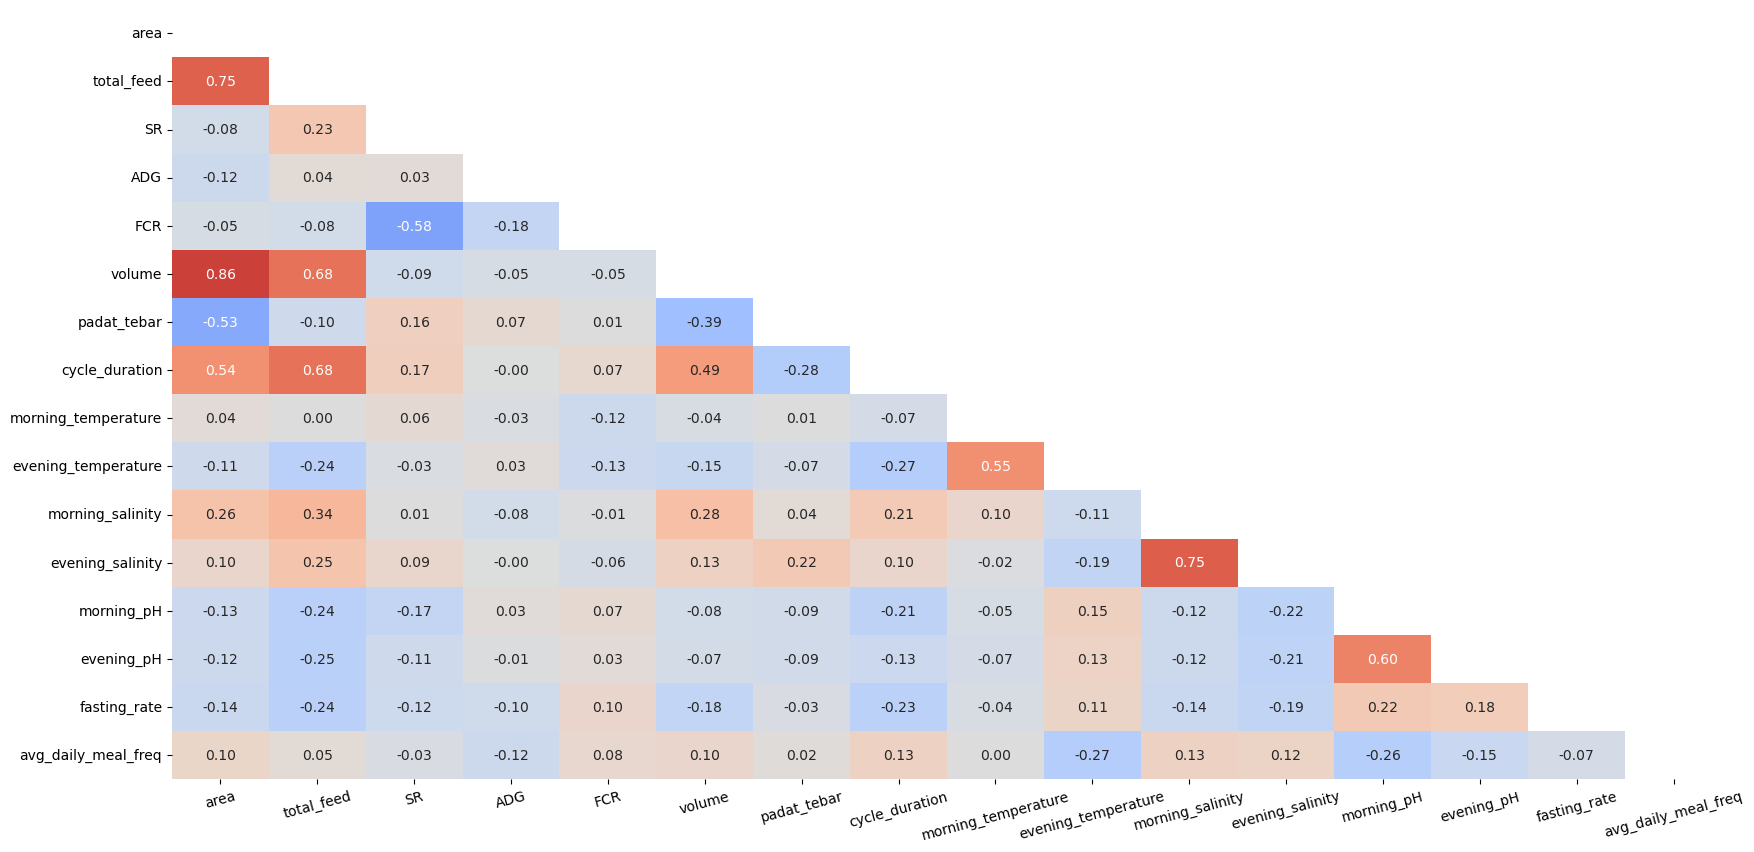

In [1529]:
corr = df2.drop('cycle_id', axis=1).corr()

# Membuat mask untuk segitiga atas
mask = np.triu(np.ones_like(corr, dtype=bool))

# Mengatur ukuran figure
plt.figure(figsize=(20, 10))

# Membuat heatmap dengan mask
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm', cbar_kws={"shrink": .8}, cbar=False)

# Menampilkan plot
plt.xticks(rotation=15)
plt.show()

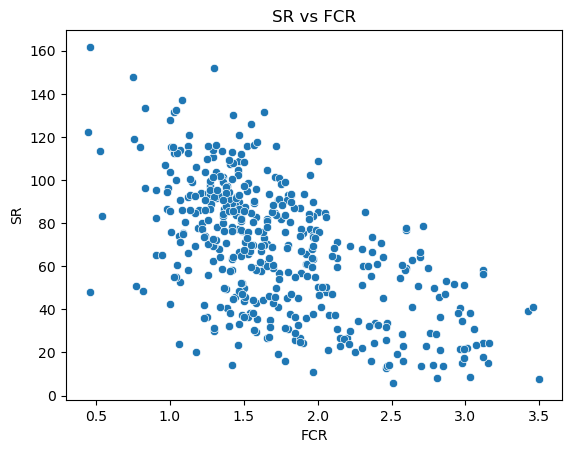

In [1530]:
sns.scatterplot(data_cleaned, x='FCR', y='SR')
plt.title('SR vs FCR');

In [1531]:
# urutan hubungan SR terbesar
df2.corr().drop(['SR','cycle_id','ADG','FCR'])['SR'].abs().sort_values(ascending=False).reset_index(name='correlation')

,index,correlation
0,total_feed,0.227230
1,morning_pH,0.173686
2,cycle_duration,0.171461
3,padat_tebar,0.159627
4,fasting_rate,0.116289
5,evening_pH,0.107323
6,volume,0.094946
7,evening_salinity,0.089076
8,area,0.079441
9,morning_temperature,0.056949


In [1532]:
# Urutan hubungan ADG terbesar
df2.corr().drop(['SR','cycle_id','ADG','FCR'])['ADG'].abs().sort_values(ascending=False).reset_index(name='correlation')

,index,correlation
0,area,0.120869
1,avg_daily_meal_freq,0.120594
2,fasting_rate,0.095250
3,morning_salinity,0.078222
4,padat_tebar,0.067516
5,volume,0.052635
6,total_feed,0.041476
7,evening_temperature,0.028645
8,morning_pH,0.028118
9,morning_temperature,0.027061


In [1533]:
# urutan hubungan FCR terbesar
df2.corr().drop(['SR','cycle_id','ADG','FCR'])['FCR'].abs().sort_values(ascending=False).reset_index(name='correlation')

,index,correlation
0,evening_temperature,0.127770
1,morning_temperature,0.124787
2,fasting_rate,0.095654
3,total_feed,0.083624
4,avg_daily_meal_freq,0.080054
5,cycle_duration,0.071342
6,morning_pH,0.068746
7,evening_salinity,0.057602
8,volume,0.052303
9,area,0.051926


## Analisis Regresi

In [1534]:
# Define independent and dependent variables for each model
independent_vars = ['area', 'cycle_duration', 'morning_temperature', 
                    'evening_temperature', 'morning_salinity', 'evening_salinity', 
                    'morning_pH', 'evening_pH', 'total_feed', 'fasting_rate', 'avg_daily_meal_freq']

# Adding constant term for intercept
X = sm.add_constant(df2[independent_vars])

# 4. Create and fit the model for SR
y_SR = df2['SR']
model_SR = sm.OLS(y_SR, X).fit()

# 5. Create and fit the model for ADG
y_ADG = df2['ADG']
model_ADG = sm.OLS(y_ADG, X).fit()

# 6. Create and fit the model for FCR
y_FCR = df2['FCR']
model_FCR = sm.OLS(y_FCR, X).fit()

# Print the summary of each model
print("Model Summary for SR:")
print(model_SR.summary())
print("\nModel Summary for ADG:")
print(model_ADG.summary())
print("\nModel Summary for FCR:")
print(model_FCR.summary())

Model Summary for SR:
                            OLS Regression Results                            
Dep. Variable:                     SR   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     11.13
Date:                Wed, 07 Aug 2024   Prob (F-statistic):           3.39e-18
Time:                        07:33:31   Log-Likelihood:                -2051.1
No. Observations:                 437   AIC:                             4126.
Df Residuals:                     425   BIC:                             4175.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const       

In [1535]:
# Menghitung VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

                feature          VIF
0                 const  3003.590161
1                  area     2.484267
2        cycle_duration     2.028393
3   morning_temperature     1.599450
4   evening_temperature     1.829412
5      morning_salinity     2.654040
6      evening_salinity     2.667844
7            morning_pH     1.746616
8            evening_pH     1.649967
9            total_feed     3.563073
10         fasting_rate     1.129643
11  avg_daily_meal_freq     1.229406


In [1536]:
df2.head()

,cycle_id,area,total_feed,SR,ADG,FCR,volume,padat_tebar,cycle_duration,morning_temperature,evening_temperature,morning_salinity,evening_salinity,morning_pH,evening_pH,fasting_rate,avg_daily_meal_freq
0,14583,1000.00,667.00,25.79,0.216667,1.85,2337.23,155.79,69.0,27.025641,29.181818,29.688750,29.601923,8.132500,8.397368,0.010,5.66
1,19049,2256.25,4383.00,110.73,0.272708,1.29,6763.83,77.56,104.0,28.283089,30.198180,15.662633,15.614264,7.800867,8.171392,0.010,4.39
2,16334,2820.00,7315.00,93.27,0.128571,1.80,3500.27,141.91,124.0,28.661000,30.629670,27.784211,27.800877,7.692982,8.280230,0.020,2.98
3,19518,1000.00,893.05,37.27,0.246726,2.08,1400.01,150.00,64.0,27.698548,29.505549,10.458040,10.176910,8.053302,8.373056,0.135,1.05
4,15005,1662.00,2909.00,78.39,0.259479,1.32,1995.00,147.48,72.0,28.438356,29.600000,23.876712,20.337333,7.824247,8.211765,0.030,5.24


## Analisis Klaster

In [1537]:
df3= df2.copy()
# df3 = df3.drop(['cycle_id','area','volume'], axis=1)
df3 = df3[['area','total_feed','SR','ADG','FCR','cycle_duration','morning_salinity','morning_pH','fasting_rate']]

In [1538]:
# standarisasi data
sc = StandardScaler()
df_trans = sc.fit_transform(df3)
df3 = pd.DataFrame(df_trans,columns=df3.columns)

In [1539]:
df3

,area,total_feed,SR,ADG,FCR,cycle_duration,morning_salinity,morning_pH,fasting_rate
0,-0.765222,-1.069426,-1.407165,-0.476100,0.237555,-0.695733,1.010797,0.858391,-0.646245
1,0.169770,0.109448,1.424525,0.234591,-0.766929,0.769498,-0.903732,-0.400319,-0.646245
2,0.589353,1.039604,0.842452,-1.593278,0.147869,1.606772,0.750832,-0.809793,-0.392280
3,-0.765222,-0.997713,-1.024450,-0.094901,0.650111,-0.905052,-1.614146,0.557795,2.528318
4,-0.272514,-0.358168,0.346389,0.066826,-0.713117,-0.570142,0.217469,-0.311581,-0.138315
...,...,...,...,...,...,...,...,...,...
432,-0.058268,0.101517,1.085816,0.714733,-0.533745,0.183405,-1.537777,0.223571,-0.646245
433,-0.002343,-0.747774,1.582545,-0.929010,-1.251234,-0.570142,1.111293,0.417166,-0.646245
434,0.351186,0.708339,0.278047,-0.417106,-0.210875,1.146271,0.565791,-0.032950,-0.392280
435,-1.453674,-1.247653,-0.904102,-0.094901,1.654596,-1.658599,-0.611987,0.412843,2.528318


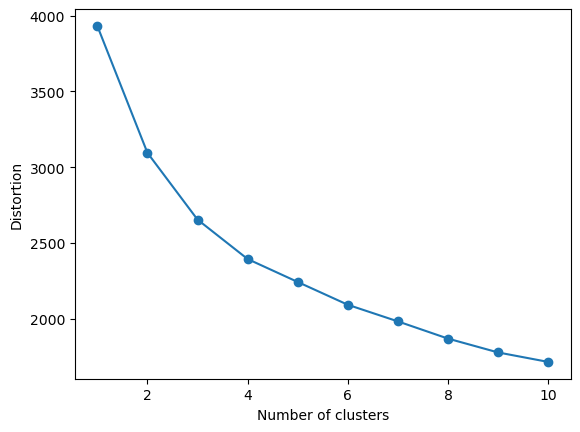

In [1540]:
# Melakukan simulasi untuk mendapatkan nilai K terbaik
distortions = []

for i  in range(1,11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(df3)
    distortions.append(km.inertia_)

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [1541]:
km = KMeans(n_clusters=3,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)

In [1542]:
clusters = km.fit(df3)
labels = km.labels_

In [1543]:
df2['Clusters'] = labels
col = df2.pop('Clusters')

# Insert the column at the desired index
df2.insert(1, 'Clusters', col)

In [1544]:
df2

,cycle_id,Clusters,area,total_feed,SR,ADG,FCR,volume,padat_tebar,cycle_duration,morning_temperature,evening_temperature,morning_salinity,evening_salinity,morning_pH,evening_pH,fasting_rate,avg_daily_meal_freq
0,14583,0,1000.00,667.00,25.79,0.216667,1.85,2337.23,155.79,69.0,27.025641,29.181818,29.688750,29.601923,8.132500,8.397368,0.010,5.66
1,19049,1,2256.25,4383.00,110.73,0.272708,1.29,6763.83,77.56,104.0,28.283089,30.198180,15.662633,15.614264,7.800867,8.171392,0.010,4.39
2,16334,2,2820.00,7315.00,93.27,0.128571,1.80,3500.27,141.91,124.0,28.661000,30.629670,27.784211,27.800877,7.692982,8.280230,0.020,2.98
3,19518,0,1000.00,893.05,37.27,0.246726,2.08,1400.01,150.00,64.0,27.698548,29.505549,10.458040,10.176910,8.053302,8.373056,0.135,1.05
4,15005,1,1662.00,2909.00,78.39,0.259479,1.32,1995.00,147.48,72.0,28.438356,29.600000,23.876712,20.337333,7.824247,8.211765,0.030,5.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,19874,1,1949.86,4358.00,100.57,0.310570,1.42,5849.57,102.57,90.0,27.686667,29.466207,11.017524,11.212651,7.965244,8.344848,0.010,4.83
433,17563,1,2025.00,1680.90,115.47,0.180952,1.02,2236.67,76.51,72.0,26.923077,28.857143,30.425000,30.346154,8.016250,8.297403,0.010,5.24
434,15066,2,2500.00,6270.80,76.34,0.221319,1.60,3750.21,125.00,113.0,28.080734,29.122772,26.428571,20.337333,7.897658,8.364144,0.020,3.97
435,15106,0,75.00,105.20,40.88,0.246726,2.64,112.50,286.38,46.0,27.527273,29.827273,17.800000,16.644444,8.015111,8.412500,0.135,1.09


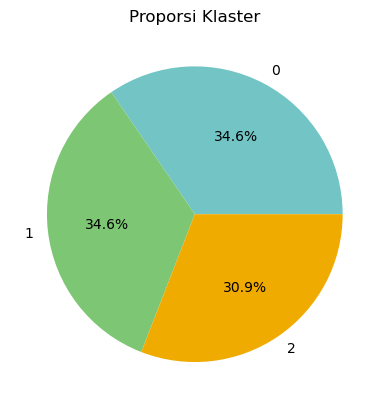

In [1545]:
klaster = df2['Clusters'].value_counts()
plt.pie(klaster.values, autopct="%1.1f%%",labels=klaster.index, colors=['#73C5C5', '#7CC674','#F0AB00', 'pink'])
plt.title('Proporsi Klaster');

In [1546]:
df2.groupby('Clusters')['SR'].mean()

Clusters
0    44.467947
1    86.602450
2    73.512667
Name: SR, dtype: float64

In [1547]:
df2.groupby('Clusters')['ADG'].mean()

Clusters
0    0.233575
1    0.288608
2    0.238814
Name: ADG, dtype: float64

In [1548]:
df2.groupby('Clusters')['FCR'].mean()

Clusters
0    2.136093
1    1.344238
2    1.667000
Name: FCR, dtype: float64

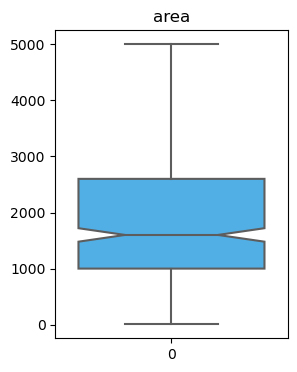

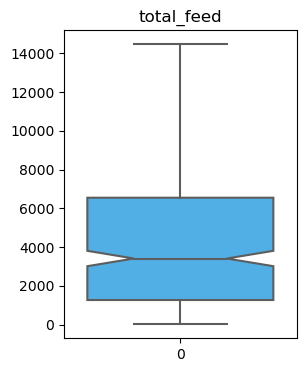

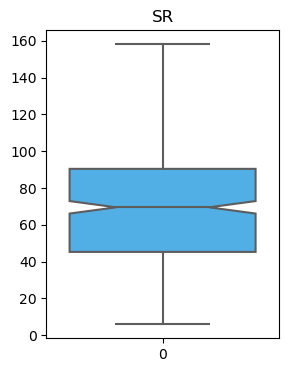

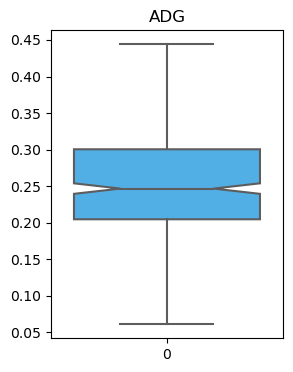

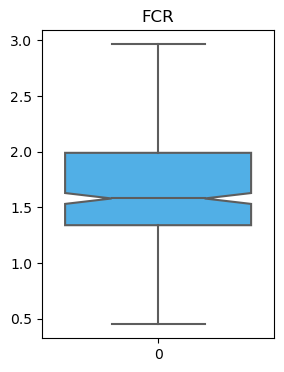

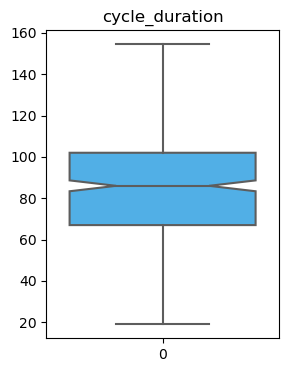

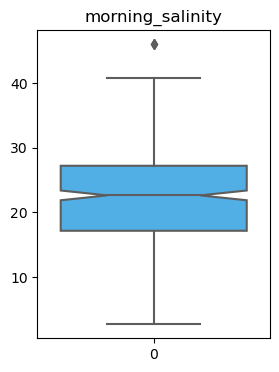

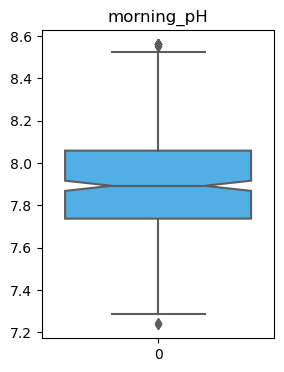

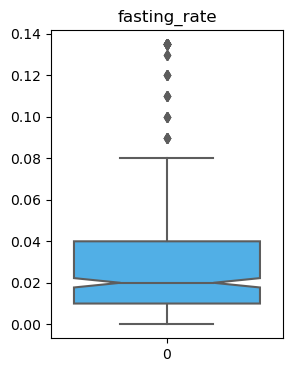

In [1549]:
for i in df3.columns:
    plt.figure(figsize=(3,4))
    sns.boxplot(df2[i], notch=True, color='#38b6ff')
    plt.title(i)

# Thank You